In [1]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Tensorflow_helper import choose_gpu_by_id
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)
# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# ------------------------------------------ import helpers
# this should import glob, os, and many other standard libs
from src.utils.Notebook_imports import *
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
# local imports
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D
from src.utils.KerasCallbacks import get_callbacks

# import external libs
import cv2
import pandas as pd

EXPERIMENT = 'temp/PhaseRegression_tests'
timestemp = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")) # ad a timestep to each project to make repeated experiments unique

MODEL_PATH = os.path.join('models', EXPERIMENT, timestemp)
TENSORBOARD_LOG_DIR = os.path.join('reports/tensorboard_logs', EXPERIMENT,timestemp)
CONFIG_PATH = os.path.join('reports/configs/',EXPERIMENT,timestemp)
HISTORY_PATH = os.path.join('reports/history/',EXPERIMENT,timestemp)

# ------------------------------------------generator hyperparameters
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 6 # 32, 64, 24, 16, 1 for 3D use: 4
GENERATOR_WORKER = BATCHSIZE # if not set, use batchsize

DIM = [10, 64, 64] # network input params for spacing of 3, (z,y,x)
T_SHAPE = 35
SPACING = [10, 4, 4] # if resample, resample to this spacing, (z,y,x)

DEPTH = 2 # depth of the encoder
FILTERS = 32 # initial number of filters, will be doubled after each downsampling block
M_POOL = [2, 2, 2]# size of max-pooling used for downsampling and upsampling
F_SIZE = [3, 3, 3] # conv filter size
BORDER_MODE = cv2.BORDER_REFLECT_101 # border mode for the data generation
IMG_INTERPOLATION = cv2.INTER_LINEAR # image interpolation in the genarator
MSK_INTERPOLATION = cv2.INTER_NEAREST # mask interpolation in the generator
AUGMENT = True # a compose of 2D augmentation (grid distortion, 90degree rotation, brightness and shift)
AUGMENT_PROB = 0.8
SHUFFLE = True
RESAMPLE = True
SCALER = 'MinMax' # MinMax Standard or Robust


DF_META = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase'
# We define 5 target phases and a background phase for the pad/empty volumes 
PHASES = len(['ED#', 'MS#', 'ES#', 'PF#', 'MD#','pad backround manually added'])
TARGET_SMOOTHING = True
SMOOTHING_KERNEL_SIZE = 10
SMOOTHING_LOWER_BORDER = 0.2
SMOOTHING_UPPER_BORDER = 0.4


Console_and_file_logger(EXPERIMENT, logging.INFO)
config = init_config(config=locals(), save=True)
print(config)
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models
['/gpu:0', '/gpu:1']


2021-02-12 15:06:04,333 INFO -------------------- Start --------------------
2021-02-12 15:06:04,334 INFO Working directory: /mnt/ssd/git/dynamic-cmr-models.
2021-02-12 15:06:04,334 INFO Log file: ./logs/temp/PhaseRegression_tests.log
2021-02-12 15:06:04,334 INFO Log level for console: INFO
2021-02-12 15:06:04,335 INFO Is built with tensorflow: True
2021-02-12 15:06:04,411 INFO Visible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2021-02-12 15:06:05,063 INFO Local devices: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18332941130773454465
, name: "/device:XLA_C

{'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'SEED': 42, 'EXPERIMENT': 'temp/PhaseRegression_tests', 'MODEL_PATH': 'models/temp/PhaseRegression_tests/2021-02-12_15_06', 'TENSORBOARD_LOG_DIR': 'reports/tensorboard_logs/temp/PhaseRegression_tests/2021-02-12_15_06', 'CONFIG_PATH': 'reports/configs/temp/PhaseRegression_tests/2021-02-12_15_06', 'HISTORY_PATH': 'reports/history/temp/PhaseRegression_tests/2021-02-12_15_06', 'BATCHSIZE': 6, 'GENERATOR_WORKER': 6, 'DIM': [10, 64, 64], 'T_SHAPE': 35, 'SPACING': [10, 4, 4], 'DEPTH': 2, 'FILTERS': 32, 'M_POOL': [2, 2, 2], 'F_SIZE': [3, 3, 3], 'BORDER_MODE': 4, 'IMG_INTERPOLATION': 1, 'MSK_INTERPOLATION': 0, 'AUGMENT': True, 'AUGMENT_PROB': 0.8, 'SHUFFLE': True, 'RESAMPLE': True, 'SCALER': 'MinMax', 'DF_META': '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase', 'PHASES': 6, 'TARGET_SMOOTHING': True, 'SMOOTHING_KERNEL_SIZE': 10, 'SMOOTHING_LOWER_BORDER': 0.2, 'SMOOTHING_UPPER_BORDER': 0.4}


In [2]:
# zip the phase files in the following structure:
#[[patient1_phase1, patient1_phase2, patient1_phase3, patient1_phase4, patient1_phase5],[patient2_phase1...] ...]

images = sorted(glob.glob('/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/*clean.nrrd'))
print(len(images))

278


In [31]:
# heck if we find each patient in the corresponding dataframe
import re
METADATA_FILE = config.get('DF_META', '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase')
df = pd.read_csv(METADATA_FILE)
DF_METADATA = df[['patient', 'ED#', 'MS#', 'ES#', 'PF#', 'MD#']]


for x in images:
    try:
        patient_str = re.search('-(.{8})_', x).group(1).upper()
        
        assert(len(patient_str) == 8), 'matched patient ID from the phase sheet has a length of: {}'.format(len(patient_str))
        # returns the indices in the following order: 'ED#', 'MS#', 'ES#', 'PF#', 'MD#'
        # reduce by one, as the indexes start at 0, the excel-sheet at 1
        ind = DF_METADATA[DF_METADATA.patient.str.contains(patient_str)][['ED#', 'MS#', 'ES#', 'PF#', 'MD#']]
        indices = ind.values[0].astype(int) -1
        
    except Exception as e:
        logging.info(patient_str)
        logging.info(ind)
        logging.info('indices: \n{}'.format(indices))

In [49]:
# The length of our onehot vector must be the length of our 4D volume
import SimpleITK as sitk
from src.data.Dataset import split_one_4d_sitk_in_list_of_3d_sitk

x = images[0]
model_inputs = split_one_4d_sitk_in_list_of_3d_sitk(sitk.ReadImage(x))
nda = [sitk.GetArrayFromImage(i) for i in model_inputs]
nda = np.stack(nda)
print(nda.shape)
# define the number of temp repeats
reps = int(np.ceil(35/nda.shape[0]))
print(reps)
nda = np.tile(nda, (reps, 1,1,1))
print(nda.shape)
METADATA_FILE = config.get('DF_META', '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase')
df = pd.read_csv(METADATA_FILE)
DF_METADATA = df[['patient', 'ED#', 'MS#', 'ES#', 'PF#', 'MD#']]


patient_str = re.search('-(.{8})_', x).group(1).upper()
ind = DF_METADATA[DF_METADATA.patient.str.contains(patient_str)][['ED#', 'MS#', 'ES#', 'PF#', 'MD#']]
indices = ind.values[0].astype(int) -1
onehot = np.zeros((indices.size, len(model_inputs)))
onehot[np.arange(indices.size), indices] = 1
print(onehot.shape)
onehot = np.tile(onehot, (1,reps))[]
print(onehot.shape)

(14, 10, 192, 138)
3
(42, 10, 192, 138)
(5, 14)
(5, 42)


In [4]:
@interact
def search_p_in_df(search_str = ''):
    return DF_METADATA[DF_METADATA['patient'].str.contains(search_str)]

interactive(children=(Text(value='', description='search_str'), Output()), _dom_classes=('widget-interact',))

In [3]:
# initialise a generator with these files
# logging.getLogger().setLevel(logging.INFO)
from src.data.Generators import PhaseRegressionGenerator
#config['SHUFFLE'] = False
#config['AUGMENT'] = False
config['RESAMPLE'] = True
batch_generator = PhaseRegressionGenerator(images, images, config=config)
val_config = config.copy()
val_config['AUGMENT'] = False
validation_generator = PhaseRegressionGenerator(images, images , config=val_config)

2021-02-12 15:06:16,586 INFO Create DataGenerator
2021-02-12 15:06:16,587 INFO Datagenerator created with: 
 shape: [10, 64, 64]
 spacing: [10, 4, 4]
 batchsize: 6
 Scaler: MinMax
 Images: 278 
 Augment: True 
 Thread workers: 6
2021-02-12 15:06:16,587 INFO Data will be augmented (shift,scale and rotate) with albumentation
2021-02-12 15:06:16,602 INFO [0.2  0.25 0.3  0.35 0.4  1.   0.4  0.35 0.3  0.25 0.2 ]
2021-02-12 15:06:16,603 INFO Create DataGenerator
2021-02-12 15:06:16,605 INFO Datagenerator created with: 
 shape: [10, 64, 64]
 spacing: [10, 4, 4]
 batchsize: 6
 Scaler: MinMax
 Images: 278 
 Augment: False 
 Thread workers: 6
2021-02-12 15:06:16,605 INFO No augmentation
2021-02-12 15:06:16,619 INFO [0.2  0.25 0.3  0.35 0.4  1.   0.4  0.35 0.3  0.25 0.2 ]


In [4]:
# visualise one batch
@interact_manual
def select_image_in_batch(batch = (0,len(batch_generator), 1), 
                          im = (0,BATCHSIZE- 1, 1), 
                          slice_n=(1,11), 
                          save=False, 
                          filepath='data/temp/', 
                          filename='temp_x.npy',
                         show_=True):
    
    import time
    global inputs, outputs
    t1 = time.time()
    inputs, outputs = batch_generator.__getitem__(batch)
    logging.info('Preprocessing took: {:0.3f}'.format(time.time() - t1))
    print(inputs.shape, outputs.shape)
    print('selected batch : ' + str(batch))
    if show_:
    
        selected_input = inputs[im]
        selected_output = outputs[im]

        logging.debug('pad: \n{}'.format(selected_output))

        list(map(lambda x: show_2D_or_3D(img=x, interpol='bilinear',dpi=100,f_size=(5,5)), selected_input[::slice_n]))
        plt.show()
        info('-'*100)
        #list(map(lambda x: show_2D_or_3D(img=x[::slice_n], interpol='bilinear',dpi=100,f_size=(5,5)), selected_output))

        """
            show_2D_or_3D(x[im], y[im], interpol='bilinear',dpi=100,f_size=(5,5))
        plt.show()
        """
        plt.hist(selected_input.flatten(), bins=np.linspace(0.1,1,20))
        plt.show()
    if save:
        ensure_dir(filepath)
        np.save(os.path.join(filepath, filename), x[im])
        logging.info('saved to {}'.format(os.path.join(filepath, filename)))
    



interactive(children=(IntSlider(value=23, description='batch', max=46), IntSlider(value=2, description='im', m…

In [5]:
for b in range(len(batch_generator)):
    print(b)
    select_image_in_batch(batch=b, slice_n=5, show_=False)

0


2021-02-12 15:06:30,837 INFO Preprocessing took: 1.078


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 0
1


2021-02-12 15:06:31,554 INFO Preprocessing took: 0.717


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 1
2


2021-02-12 15:06:32,650 INFO Preprocessing took: 1.096


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 2
3


2021-02-12 15:06:33,455 INFO Preprocessing took: 0.805


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 3
4


2021-02-12 15:06:34,503 INFO Preprocessing took: 1.047


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 4
5


2021-02-12 15:06:35,570 INFO Preprocessing took: 1.066


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 5
6


2021-02-12 15:06:36,337 INFO Preprocessing took: 0.767


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 6
7


2021-02-12 15:06:37,305 INFO Preprocessing took: 0.967


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 7
8


2021-02-12 15:06:37,854 INFO Preprocessing took: 0.549


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 8
9


2021-02-12 15:06:38,834 INFO Preprocessing took: 0.979


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 9
10


2021-02-12 15:06:39,507 INFO Preprocessing took: 0.672


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 10
11


2021-02-12 15:06:40,153 INFO Preprocessing took: 0.646


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 11
12


2021-02-12 15:06:40,810 INFO Preprocessing took: 0.657


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 12
13


2021-02-12 15:06:41,727 INFO Preprocessing took: 0.916


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 13
14


2021-02-12 15:06:42,404 INFO Preprocessing took: 0.676


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 14
15


2021-02-12 15:06:43,064 INFO Preprocessing took: 0.660


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 15
16


2021-02-12 15:06:44,224 INFO Preprocessing took: 1.159


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 16
17


2021-02-12 15:06:44,992 INFO Preprocessing took: 0.768


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 17
18


2021-02-12 15:06:46,033 INFO Preprocessing took: 1.041


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 18
19


2021-02-12 15:06:46,763 INFO Preprocessing took: 0.729


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 19
20


2021-02-12 15:06:47,782 INFO Preprocessing took: 1.019


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 20
21


2021-02-12 15:06:48,845 INFO Preprocessing took: 1.063


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 21
22


2021-02-12 15:06:49,559 INFO Preprocessing took: 0.714


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 22
23


2021-02-12 15:06:50,110 INFO Preprocessing took: 0.550


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 23
24


2021-02-12 15:06:50,877 INFO Preprocessing took: 0.766


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 24
25


2021-02-12 15:06:51,652 INFO Preprocessing took: 0.774


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 25
26


2021-02-12 15:06:52,555 INFO Preprocessing took: 0.903


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 26
27


2021-02-12 15:06:53,459 INFO Preprocessing took: 0.903


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 27
28


2021-02-12 15:06:54,312 INFO Preprocessing took: 0.853


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 28
29


2021-02-12 15:06:54,917 INFO Preprocessing took: 0.604


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 29
30


2021-02-12 15:06:55,743 INFO Preprocessing took: 0.826


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 30
31


2021-02-12 15:06:56,481 INFO Preprocessing took: 0.738


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 31
32


2021-02-12 15:06:57,355 INFO Preprocessing took: 0.874


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 32
33


2021-02-12 15:06:58,023 INFO Preprocessing took: 0.667


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 33
34


2021-02-12 15:06:58,908 INFO Preprocessing took: 0.885


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 34
35


2021-02-12 15:06:59,436 INFO Preprocessing took: 0.528


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 35
36


2021-02-12 15:07:00,667 INFO Preprocessing took: 1.230


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 36
37


2021-02-12 15:07:01,365 INFO Preprocessing took: 0.697


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 37
38


2021-02-12 15:07:02,173 INFO Preprocessing took: 0.808


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 38
39


2021-02-12 15:07:02,850 INFO Preprocessing took: 0.676


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 39
40


2021-02-12 15:07:03,907 INFO Preprocessing took: 1.057


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 40
41


2021-02-12 15:07:04,771 INFO Preprocessing took: 0.864


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 41
42


2021-02-12 15:07:05,599 INFO Preprocessing took: 0.828


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 42
43


2021-02-12 15:07:06,800 INFO Preprocessing took: 1.200


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 43
44


2021-02-12 15:07:07,716 INFO Preprocessing took: 0.916


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 44
45


2021-02-12 15:07:08,581 INFO Preprocessing took: 0.865


(6, 35, 10, 64, 64, 1) (6, 35, 6)
selected batch : 45


In [10]:
from src.models.Models import create_PhaseRegressionModel
model = create_PhaseRegressionModel(config)

(None, 2, 16, 16, 128)
gap elem 0
(None, 128)
concat all
(None, 35, 128)
conv1d 256, 5, 2
(None, 35, 32)
(None, 35, 32)
(None, 35, 6)


In [11]:
model.summary(line_length=150)

Model: "PhaseRegressionModel"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_2 (InputLayer)                             [(None, 35, 10, 64, 64, 1)]      0                                                                   
______________________________________________________________________________________________________________________________________________________
tf_op_layer_unstack_1 (TensorFlowOpLayer)        [(None, 10, 64, 64, 1), (None, 1 0                 input_2[0][0]                                     
______________________________________________________________________________________________________________________________________________________
conv_encoder_1 (ConvEncoder)                     ((None, 2, 16, 

In [12]:
initial_epoch = 0

results = model.fit(
    x=batch_generator,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=200,
    callbacks = get_callbacks(config, validation_generator),
    steps_per_epoch = len(batch_generator),
    initial_epoch=initial_epoch,
    max_queue_size=20,
    workers=2,
    use_multiprocessing=False,
    verbose=1)

Epoch 1/200
46/46 [==============================] - 87s 2s/step - loss: 0.1018 - categorical_accuracy: 0.4596 - accuracy: 0.3919 - val_loss: 0.2580 - val_categorical_accuracy: 0.1513 - val_accuracy: 0.3759 - lr: 0.0010
Epoch 2/200
46/46 [==============================] - 83s 2s/step - loss: 0.0360 - categorical_accuracy: 0.5268 - accuracy: 0.4201 - val_loss: 0.2239 - val_categorical_accuracy: 0.2032 - val_accuracy: 0.3923 - lr: 0.0010
Epoch 3/200
46/46 [==============================] - 85s 2s/step - loss: 0.0337 - categorical_accuracy: 0.5350 - accuracy: 0.4299 - val_loss: 0.4788 - val_categorical_accuracy: 0.2479 - val_accuracy: 0.3556 - lr: 0.0010
Epoch 4/200
46/46 [==============================] - 86s 2s/step - loss: 0.0319 - categorical_accuracy: 0.5378 - accuracy: 0.4320 - val_loss: 0.6070 - val_categorical_accuracy: 0.2652 - val_accuracy: 0.3314 - lr: 0.0010
Epoch 5/200
46/46 [==============================] - 84s 2s/step - loss: 0.0315 - categorical_accuracy: 0.5550 - accurac

(3, 3)


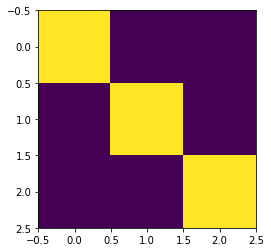

(1, 5)


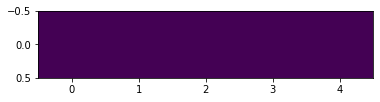

(2, 5)


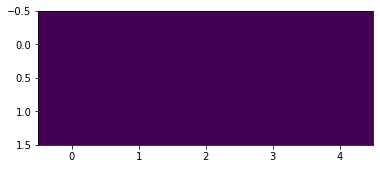

In [30]:
temp = np.eye(3)
print(temp.shape)
plt.imshow(temp)
plt.show()
temp2 = np.zeros((1,5))
print(temp2.shape)
plt.imshow(temp2)
plt.show()

temp3 = np.tile(temp2, (2,1))
print(temp3.shape)
plt.imshow(temp3)
plt.show()

# Generator tests

In [ ]:
temp = outputs[0][:]
plt.imshow(temp)

In [ ]:
t = np.concatenate([temp, temp])
print(t.shape)
first, second = np.split(t, indices_or_sections=2)
print(first.shape)
temp = np.maximum(first,second)
print(temp.shape)

In [ ]:
nonempty_timesteps = (np.sum(temp,axis=1)==0).astype(int)
nonempty_timesteps.shape
nonempty_timesteps

In [ ]:
nonempty_timesteps[:,None].shape


In [ ]:
np.concatenate([temp, nonempty_timesteps[:,None]], axis=1).shape

In [ ]:
temp = outputs[0][:]
print(temp.shape)
print(temp)
print(temp.sum(axis=0))
print(temp.T)

In [ ]:
onehot = np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]])

In [ ]:
onehot.shape

In [ ]:
onehot_t = onehot.T
onehot_t.shape
onehot_t

In [ ]:
print(np.argmax(onehot, axis=1))
print(np.argmax(onehot_t, axis=0))

In [ ]:
# iterate over the phases j
# linspace from i to i+1 from indices
temp = onehot_t[:,0].astype(float)
i = 0
j = 3 + 1
temp[i:j] = np.linspace(i,j,j-i)
temp

In [ ]:
onehot_t = onehot_t.astype(float)
indices = np.argmax(onehot_t, axis=0)
for i in range(onehot_t.shape[1]) :
    start = indices[i]
    # make it a ring
    second = (i+1)%len(indices)
    end = indices[second]
    onehot_t[start:end,i] = np.linspace(1,0,int(end-start))
onehot_t
             
    

In [ ]:
# smooth the one-hot vectors along the indexes
# each phase has a small range of valid indexes with a convolved smoothing
import sys
temp = np.copy(outputs[0])
kernelsize = 5
lower = 0.1
upper = 0.5
# create a kernel with linearly increasing, than one, than decreasing smoothing
kernel = np.concatenate([np.linspace(lower,upper,kernelsize//2), [1], np.linspace(upper,lower,kernelsize//2)])
print('Kernel: {}'.format(kernel))
for idx in range(temp.shape[0]):
    print(temp[idx])
    smoothed = np.convolve(temp[idx],kernel, mode='same')
    print('convolved: {}'.format(smoothed))
    smoothed = smoothed/(sum(smoothed) + sys.float_info.epsilon)
    print('normalised: {}'.format(smoothed))
    temp[idx] = smoothed


In [ ]:
plt.imshow(temp)

In [ ]:
plt.imshow(temp.T)

In [ ]:
# load phase indicies from the df
print(len(images))
patient_temp = images[0]
# search for the 8 digits of the patient ID which should have a underscore in before and than a minus
patient_str = re.search('-(.{8})_', patient_temp).group(1)
df = pd.read_csv('/mnt/ssd/data/gcn/02_imported_4D_unfiltered_old/SAx_3D_dicomTags_phase')
df = df[['patient', 'ED#', 'MS#', 'ES#', 'PF#', 'MD#']]
df[df.patient.str.contains(patient_str)][['ED#', 'MS#', 'ES#', 'PF#', 'MD#']].values[0].astype(int) -1

In [ ]:
import re
a = get_patient(patient_temp)

re.search('-(.{8})_', patient_temp).group(1)

In [ ]:
%%timeit
temp.mean()

In [ ]:
%%timeit
np.mean(temp)

In [ ]:
np.linspace(-1,1,10)